# 2. Confined Aquifer Test - Grindley
**This test is taken from AQTESOLV examples.**

## Introduction and Conceptual Model

In this example, we reproduce the work of Yang (2020) to use the pumping test data to demonstrate how TTim can be used to model and analyze pumping tests in a single layer, confined setting. Furthermore, we compare the performance of TTim with other transient well hydraulics software AQTESOLV (Duffield, 2007) and MLU (Carlson and Randall, 2012).

This example is a pumping test conducted in 1953 in Grindley, Illinois, US. It was reported by Walton (1962). The aquifer is an 18 ft thickness sand and gravel layer under confined conditions. The pumping well fully penetrates the formation, and pumping was conducted for 8 hours at a rate of 220 gallons per minute. The effect of pumping was observed at observation well 1, located 824 ft away from the well.

The time-drawdown data for the observation well was obtained from AQTESOLV documentation (Duffield, 2007), while data from the pumping well was obtained from the original paper from Walton (1962). Following AQTESOLV documentation (Duffield, 2007), we have assumed that both well and observation well radii are 0.5 ft.

A simplified cross-section of the model area can be seen below:

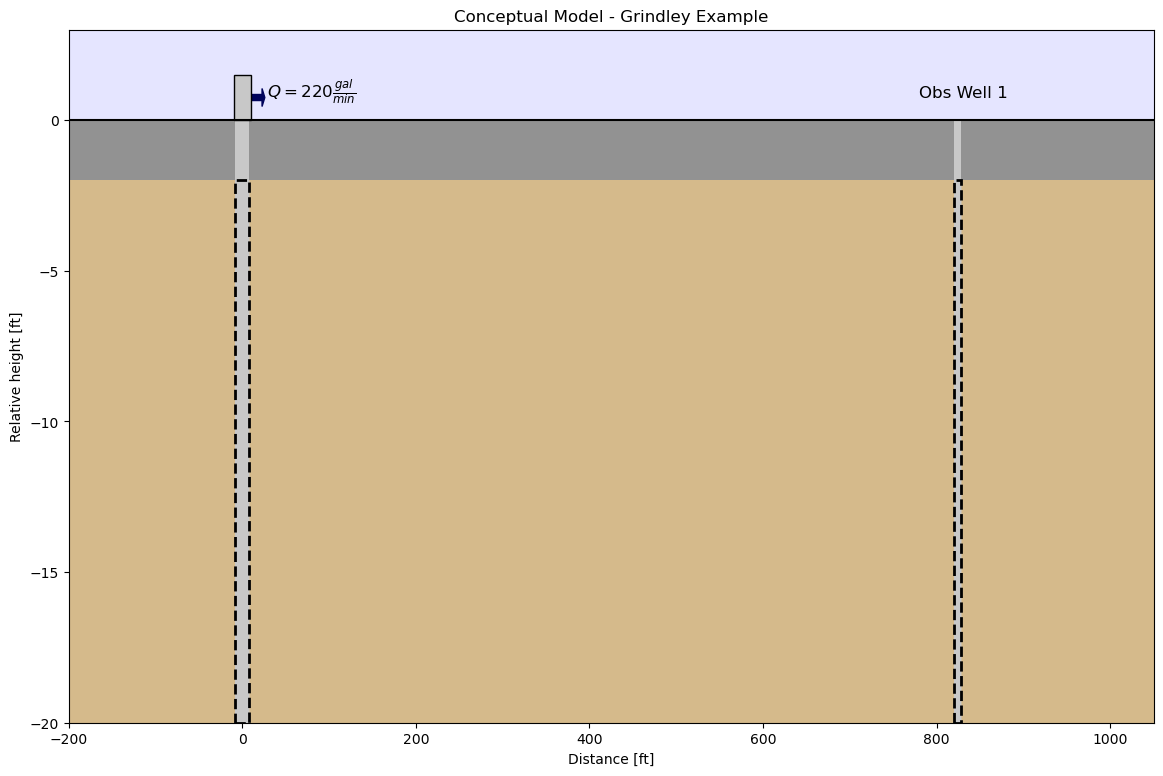

In [11]:
import matplotlib.pyplot as plt
import numpy as np

##Now printing the conceptual model figure:

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(1,1,1)
#sky
sky = plt.Rectangle((-200,0), width = 1400, height = 3, fc = 'b', zorder=0, alpha=0.1)
ax.add_patch(sky)

#Aquifer:
ground = plt.Rectangle((-200,-20), width = 1400, height = 18, fc = np.array([209,179,127])/255, zorder=0, alpha=0.9)
ax.add_patch(ground)

#Confining bed:
confining_unit = plt.Rectangle((-200,-2), width = 1400, height = 2, fc = np.array([100,100,100])/255, zorder=0, alpha=0.7)
ax.add_patch(confining_unit)
well = plt.Rectangle((-8,-20), width = 16, height = 20, fc = np.array([200,200,200])/255, zorder=1)
ax.add_patch(well)

#Wellhead
wellhead = plt.Rectangle((-10,0),width = 20, height = 1.5, fc = np.array([200,200,200])/255, zorder=2, ec='k')
ax.add_patch(wellhead)

#Screen for the well:
screen = plt.Rectangle((-8,-20), width = 16, height = 18, fc = np.array([200,200,200])/255, alpha=1, zorder = 2, ec = "k", ls = '--')
screen.set_linewidth(2)
ax.add_patch(screen)
pumping_arrow = plt.Arrow(x = 10,y = 0.75, dx = 16, dy = 0, color = "#00035b")
ax.add_patch(pumping_arrow)
ax.text(x = 29, y = 0.75, s = r'$ Q = 220 \frac{gal}{min}$', fontsize = 'large' )
#Piezometers
piez1 = plt.Rectangle((820,-20), width = 8, height = 20,fc = np.array([200,200,200])/255, zorder=1)
screen_piez_1 = plt.Rectangle((820,-20), width = 8, height = 18, fc = np.array([200,200,200])/255, alpha=1, zorder = 2, ec = "k", ls = '--')
screen_piez_1.set_linewidth(2)

ax.add_patch(piez1)

ax.add_patch(screen_piez_1)

#last line
line = plt.Line2D(xdata= [-200,1200], ydata = [0,0], color = "k")
ax.add_line(line)
ax.text(x = 780, y = 0.75, s = 'Obs Well 1', fontsize = 'large' )

ax.set_xlim([-200,1050])
ax.set_ylim([-20,3])
ax.set_xlabel('Distance [ft]')
ax.set_ylabel('Relative height [ft]')
ax.set_title('Conceptual Model - Grindley Example');

## Step 1. Load required libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ttim

## Step 2. Set basic parameters

- We will work with time in days and length in meters from this step onwards
- The parameters below have already been converted to m and days.

In [13]:
b = -5.4846 #aquifer thickness in m (Converted from 18 ft)
Q = 1199.218 #constant discharge in m^3/d (Converted from 220 gallons/minute)
r = 251.1552 #distance between observation well to test well in m (Converted from 824 ft)
rw = 0.1524 #screen radius of test well in m (Converted from 0.5 ft)

## Step 3. Load data of observation and pumping well

The preferred method of loading data into TTim is to use numpy arrays.

The data is in a text file where the first column is the time data in ***days*** and the second column is the drawdown in ***meters***

The observation well is referred to as ***Well 1*** and the pumping well as ***Well 3***.

For each piezometer, we will load the data as a numpy array and split time and drawdown into two different 1d arrays.

In [14]:
# Loading Observation well (Well 1)
data1 = np.loadtxt('data/gridley_well_1.txt')
t1 = data1[:, 0]
h1 = data1[:, 1]

# Loading Pumping Well data (Well 3)
data2 = np.loadtxt('data/gridley_well_3.txt')
t2 = data2[:, 0]
h2 = data2[:, 1]

<a id='step_4'></a>
## Step 4. Creating a TTim conceptual model

In this example, we are using the ModelMaq model to conceptualize our aquifer. ModelMaq defines the aquifer system as a stacked vertical sequence of aquifers and leaky layers (aquifer-leaky layer, aquifer-leaky layer etc). A thorough explanation of the ModelMaq and TTim one-layer modelling conceptualization is given in the notebook: [Confined 1 - Oude Korendijk](confined1_oude_korendijk)

In [15]:
ml = ttim.ModelMaq(kaq=10, z=[0, b], Saq=0.001, tmin=0.001, tmax=1, topboundary='conf')
w = ttim.Well(ml, xw=0, yw=0, rw=rw, tsandQ=[(0, Q)], layers=0)
ml.solve()

self.neq  1
solution complete


## Step 5. Calibration

The calibration workflow has been described in detail in the notebook: [Confined 1 - Oude Korendijk](confined1_oude_korendijk)

<a id='step_5_1'></a>
### Step 5.1. Calibration Using the Observation Well

We begin the calibration using the data from observation well (well 1) as our data set.

In [16]:
#unknown parameters: kaq, Saq
ca_0 = ttim.Calibrate(ml) # Create the Calibrate object, calling the model to the object
ca_0.set_parameter(name='kaq0', initial=10) # Setting the parameters for calibration
ca_0.set_parameter(name='Saq0', initial=1e-4)
ca_0.series(name='obs1', x=r, y=0, t=t1, h=h1, layer=0) # Setting the observation data
ca_0.fit(report=True) # Fitting the model. We can hide the message below setting report = False

..................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 22
    # variables        = 2
    chi-square         = 0.01702168
    reduced chi-square = 8.5108e-04
    Akaike info crit   = -153.614816
    Bayesian info crit = -151.432731
[[Variables]]
    kaq0:  22.4340266 +/- 0.22268654 (0.99%) (init = 10)
    Saq0:  3.8208e-06 +/- 7.4239e-08 (1.94%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.8829


The results from calibration are stored in the ```.parameters``` attribute of the calibration object.
We can also call the ```.rmse``` method to check the fitting error (RMSE)

In [17]:
display(ca_0.parameters)
print('rmse:', ca_0.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,22.434027,2.226865e-01,0.992628,-inf,inf,10.0000,[22.43402657500395]
Saq0,0.000004,7.423925e-08,1.943042,-inf,inf,0.0001,[3.8207741931644555e-06]


rmse: 0.027815693150943354


Now, we plot the model with our observation data:

* First, we have to compute the model calculated heads at the observation location. For this, we use the ```.head```method in the model object (```ml```). This method takes the following arguments
    * the positions ```x``` and ```y``` of the piezometric well (or any other point of interest). In our case, our well is located at position ```x= r1``` and ```y = 0```.
    * the time intervals, defined by the numpy array ```t```, for the computation of the heads. In our case, this is defined by the variable ```t1```.

    * Another optional input is ```layers```, which can be a list, integer or an array defining the model layers. When we do not assign anything, the head is computed for all layers.

The output is a numpy array with dimensions ```(nl,nt)```, where ```nl``` is the number of layers and ```nt``` is the number of time intervals.

* Now, we can compare both observations and predictions in a plot:

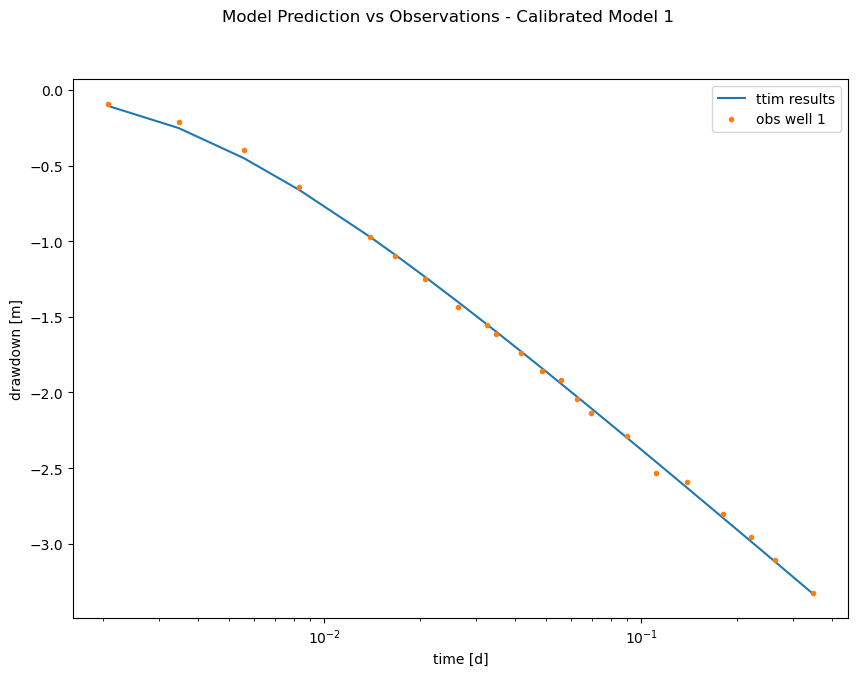

In [18]:
hm_0 = ml.head(x = r, y = 0, t = t1) # Compute heads at observation well location
plt.figure(figsize = (10, 7))
plt.semilogx(t1, hm_0[0], label = 'ttim results') # Plotting TTim model Results
plt.semilogx(t1, h1, '.', label = 'obs well 1') # Plotting Observed points
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.suptitle('Model Prediction vs Observations - Calibrated Model 1')
plt.legend();

Now let's check how it performs with the Pumping Well data:


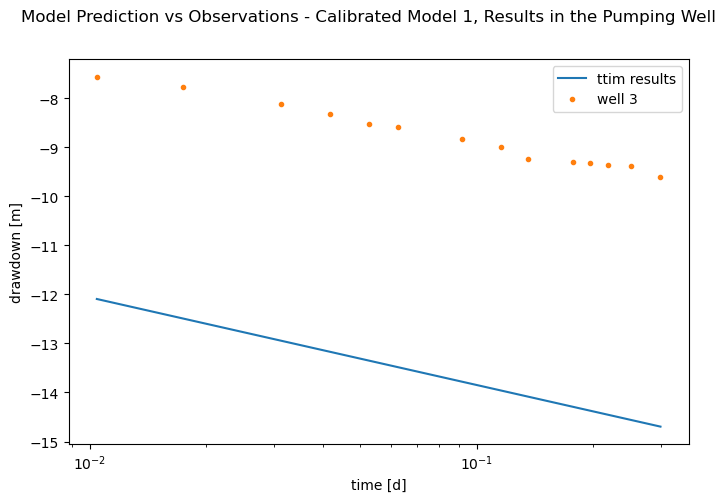

In [19]:
hm_0_2 = ml.head(x = 0, y = 0, t = t2) # Compute heads at observation well location
plt.figure(figsize = (8, 5))
plt.semilogx(t2, hm_0_2[0], label = 'ttim results') # Plotting TTim model Results
plt.semilogx(t2, h2, '.', label = 'well 3') # Plotting Observed points
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.suptitle('Model Prediction vs Observations - Calibrated Model 1, Results in the Pumping Well')
plt.legend();

As we can see, although the model presented an initial good fit, when we challenged it with an outside sample, it performed poorly.

### Step 5.2. Calibration using the Pumping Well data

We proceed to calibrate using only the data from the pumping well (Well 3).
The initial inputs can be checked in [***step 5.1***](#step_5_1)

In [20]:
#unknown parameters: kaq, Saq
ca_1 = ttim.Calibrate(ml)
ca_1.set_parameter(name='kaq0', initial=10)
ca_1.set_parameter(name='Saq0', initial=1e-4)
ca_1.series(name='well3', x=0, y=0, t=t2, h=h2, layer=0)
ca_1.fit(report=True)

...........................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 24
    # data points      = 14
    # variables        = 2
    chi-square         = 0.04383685
    reduced chi-square = 0.00365307
    Akaike info crit   = -76.7287306
    Bayesian info crit = -75.4506160
[[Variables]]
    kaq0:  27.8987411 +/- 0.73011666 (2.62%) (init = 10)
    Saq0:  1.7023e-04 +/- 5.8161e-05 (34.17%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.9971


In [21]:
ca_1.parameters
print('rmse:', ca_1.rmse())

rmse: 0.05595715606295086


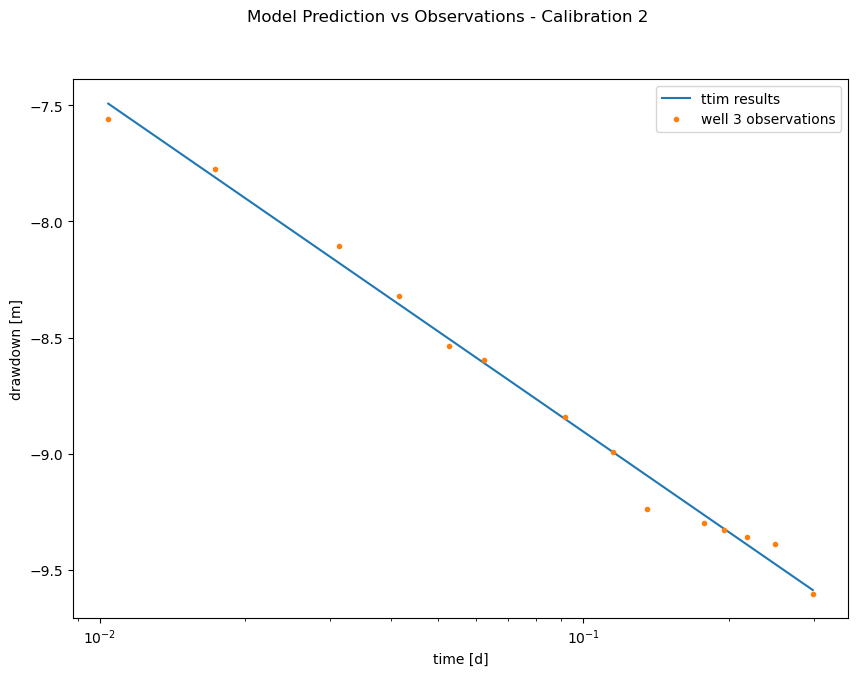

In [22]:
hm_1 = ml.head(0, 0, t2)
plt.figure(figsize = (10, 7))
plt.semilogx(t2, hm_1[0], label = 'ttim results')
plt.semilogx(t2, h2, '.', label = 'well 3 observations')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.suptitle('Model Prediction vs Observations - Calibration 2')
plt.legend();

### Step 5.3. Model Calibration with both datasets

We now will proceed to calibrate the model using both datasets at the same time. We begin by creating a new model so we can compare the different results later:

In [23]:
ml_1 = ttim.ModelMaq(kaq=10, z=[0, b], Saq=0.001, tmin=0.001, tmax=1, topboundary='conf')
w_1 = ttim.Well(ml_1, xw=0, yw=0, rw=rw, tsandQ=[(0, Q)], layers=0)
ml_1.solve()

self.neq  1
solution complete


We now create a new ```Calibrate``` object. The difference from the previous calibration objects is that now we add a second observation series to the object:

In [24]:
ca_2 = ttim.Calibrate(ml_1)
ca_2.set_parameter(name='kaq0', initial=10)
ca_2.set_parameter(name='Saq0', initial=1e-4, pmin=0)
ca_2.series(name='obs1', x=r, y=0, t=t1, h=h1, layer=0) # Adding observation Well 1
ca_2.series(name='well3', x=0, y=0, t=t2, h=h2, layer=0)# Adding Pumping Well (Well 3)
ca_2.fit(report=True)

............................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 36
    # variables        = 2
    chi-square         = 2.65994093
    reduced chi-square = 0.07823356
    Akaike info crit   = -89.7877408
    Bayesian info crit = -86.6207029
[[Variables]]
    kaq0:  38.0492316 +/- 0.52463395 (1.38%) (init = 10)
    Saq0:  1.2468e-06 +/- 2.0176e-07 (16.18%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.7694


In [25]:
display(ca_2.parameters)
print('rmse:', ca_2.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,38.049232,5.246339e-01,1.378829,-inf,inf,10.0000,[38.049231613692605]
Saq0,0.000001,2.017624e-07,16.182382,0.0,inf,0.0001,[1.2468025740730582e-06]


rmse: 0.2718220890129378


The parameters are quite different from the first two models. We can also see that the errors have increased significantly. Let's plot the model results with the observations and check why we have large errors:

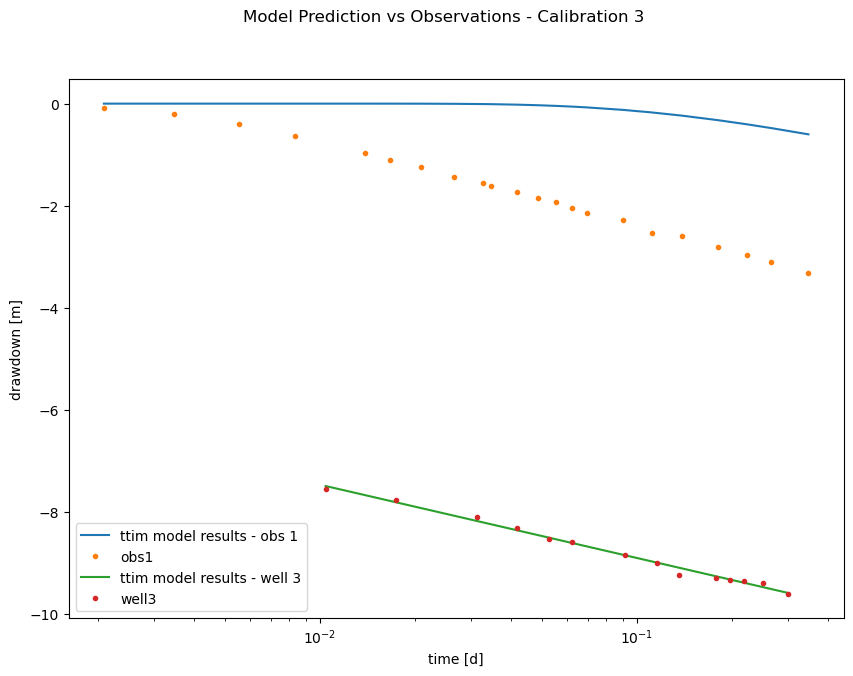

In [26]:
hm1_2 = ml.head(r, 0, t1)
hm2_2 = ml.head(0, 0, t2)
plt.figure(figsize = (10, 7))
plt.semilogx(t1, hm1_2[0], label = 'ttim model results - obs 1')
plt.semilogx(t1, h1, '.', label = 'obs1')
plt.semilogx(t2, hm2_2[0], label = 'ttim model results - well 3')
plt.semilogx(t2, h2, '.', label = 'well3')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.suptitle('Model Prediction vs Observations - Calibration 3')
plt.legend();

As seen in the Figure above, TTim could not adjust both curves simultaneously and ended up fitting only Well 3.

Fortunately, in TTim, we can improve this fit by simulating skin resistance and wellbore storage.

### Step 5.4. Model Calibration with skin resistance and wellbore storage

For this, we create a new model and add two extra parameters to the ```Well``` object:

* The radius of the caisson ```rc```, which we use to simulate wellbore storage. In this case, we use a value in meters (float). The function of the radius of the caisson to account for wellbore storage is explained in the previous notebook: [Confined 1 - Oude Korendijk](confined1_oude_korendijk);
* The skin resistance ```res```, a float value unit of time (in our case days). The effect of the skin resistance is explained in [Confined 1 - Oude Korendijk](confined1_oude_korendijk).

In [27]:
ml_2 = ttim.ModelMaq(kaq=10, z=[0, b], Saq=0.001, tmin=0.001, tmax=1, topboundary='conf')
w_2 = ttim.Well(ml_2, xw=0, yw=0, rw=rw, rc=0.2, res=0.2, tsandQ=[(0, Q)], layers=0)
ml_2.solve()

self.neq  1
solution complete


Here we use the method ```.set_parameter_by_reference``` to calibrate the ```rc``` and ```res``` parameters in our well.

```.set_parameter_by_reference``` takes the following arguments:
* ```name```: a string of the parameter name
* ```parameter```: numpy-array with the parameter to be optimized. It should be specified as a reference, for example, in our case: ```w1.rc[0:]``` referencing to the parameter ```rc``` in object ```w1```.
* ```initial```: float with the initial guess for the parameter value.
* ```pmin``` and ```pmax```: floats with the minimum and maximum values allowed. If not specified, these will be ```-np.inf``` and ```np.inf```.

In [28]:
ca_3 = ttim.Calibrate(ml_2)
ca_3.set_parameter(name = 'kaq0', initial = 10)
ca_3.set_parameter(name = 'Saq0', initial = 1e-4, pmin=0)
ca_3.set_parameter_by_reference(name='res', parameter=w_2.res, initial =0.2, pmin = 0) # Here we add pmin = 0 to avoid unrealistic values
ca_3.set_parameter_by_reference(name='rc', parameter=w_2.rc, initial = 0.2)
ca_3.series(name='obs1', x=r, y=0, t=t1, h=h1, layer=0)
ca_3.series(name='obs3', x=0, y=0, t=t2, h=h2, layer=0)
ca_3.fit(report=True)

.

..............................................................................................................................................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 188
    # data points      = 36
    # variables        = 4
    chi-square         = 1.29522940
    reduced chi-square = 0.04047592
    Akaike info crit   = -111.693920
    Bayesian info crit = -105.359844
[[Variables]]
    kaq0:  38.2995471 +/- 0.40273920 (1.05%) (init = 10)
    Saq0:  8.9358e-07 +/- 1.1726e-07 (13.12%) (init = 0.0001)
    res:   6.0492e-06 +/- 0.01070643 (176989.84%) (init = 0.2)
    rc:    0.42247557 +/- 0.07071625 (16.74%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(res, rc)    = -0.9172
    C(kaq0, Saq0) = -0.7472
    C(Saq0, rc)   = -0.1770
    C(kaq0, res)  = -0.1645
    C(kaq0, rc)   = +0.1393


<a id='adjusted_pars_ca_3'></a>

In [29]:
display(ca_3.parameters)
print('rmse:', ca_3.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,3.829955e+01,4.027392e-01,1.051551,-inf,inf,10.0000,[38.29954705235744]
Saq0,8.935817e-07,1.172566e-07,13.122087,0.0,inf,0.0001,[8.935816591115753e-07]
res,6.049176e-06,1.070643e-02,176989.839759,0.0,inf,0.2000,[6.04917587931908e-06]
rc,4.224756e-01,7.071625e-02,16.738542,-inf,inf,0.2000,[0.42247557130811325]


rmse: 0.18968024268277686


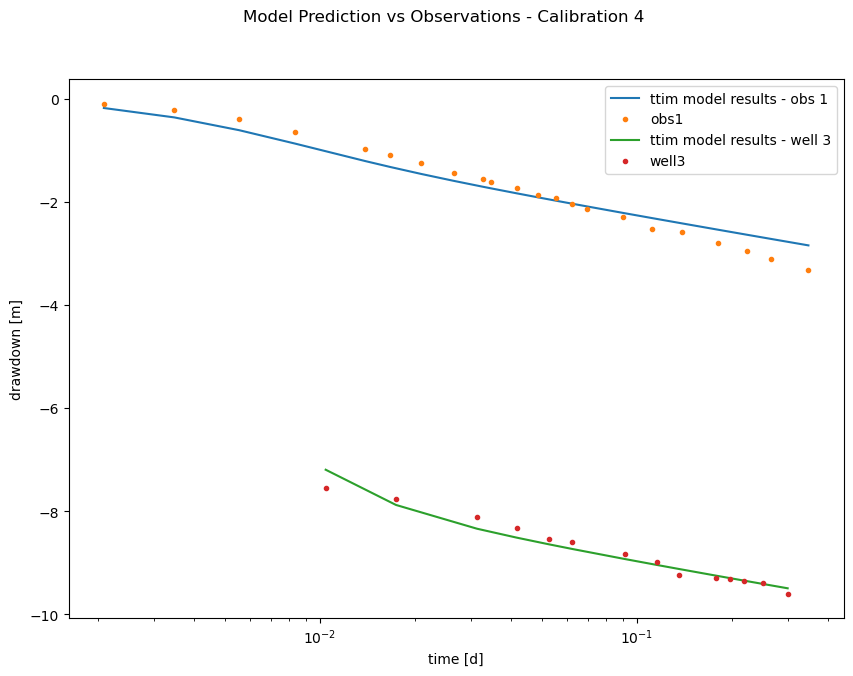

In [30]:
hm1_3 = ml_2.head(r, 0, t1)
hm2_3 = ml_2.head(0, 0, t2)
plt.figure(figsize = (10, 7))
plt.semilogx(t1, hm1_3[0], label = 'ttim model results - obs 1')
plt.semilogx(t1, h1, '.', label = 'obs1')
plt.semilogx(t2, hm2_3[0], label = 'ttim model results - well 3')
plt.semilogx(t2, h2, '.', label = 'well3')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.suptitle('Model Prediction vs Observations - Calibration 4')
plt.legend();

Here, we see in the picture that we have significantly improved both models by adding the resistance and the wellbore storage. We can make a critique of our current model that the adjusted resistance value is too low and with a very high standard deviation ([adjusted parameters](#adjusted_pars_ca_3)). Let's now disregard the skin resistance and check our model performance.

## Step 5.5. Model Calibration with wellbore storage

We start by creating a model and adding a well with no resistance:

In [31]:
ml_3 = ttim.ModelMaq(kaq=10, z=[0, b], Saq=0.001, tmin=0.001, tmax=1, topboundary='conf')
w_3 = ttim.Well(ml_3, xw=0, yw=0, rw=rw, rc=0.2, res=0, tsandQ=[(0, Q)], layers=0)
ml_3.solve()

self.neq  1
solution complete


Now we calibrate without changing the resistance parameter

In [32]:
ca_4 = ttim.Calibrate(ml_3)
ca_4.set_parameter(name = 'kaq0', initial = 10)
ca_4.set_parameter(name = 'Saq0', initial = 1e-4, pmin=0)
ca_4.set_parameter_by_reference(name='rc', parameter=w_3.rc, initial = 0.2)
ca_4.series(name='obs1', x=r, y=0, t=t1, h=h1, layer=0)
ca_4.series(name='obs3', x=0, y=0, t=t2, h=h2, layer=0)
ca_4.fit(report=True)

..................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 36
    # variables        = 3
    chi-square         = 1.29522429
    reduced chi-square = 0.03924922
    Akaike info crit   = -113.694062
    Bayesian info crit = -108.943506
[[Variables]]
    kaq0:  38.2995706 +/- 0.39115142 (1.02%) (init = 10)
    Saq0:  8.9400e-07 +/- 1.1516e-07 (12.88%) (init = 0.0001)
    rc:    0.42216584 +/- 0.02778676 (6.58%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.7468
    C(Saq0, rc)   = -0.2667


In [33]:
display(ca_4.parameters)
print('rmse:', ca_4.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,3.829957e+01,3.911514e-01,1.021295,-inf,inf,10.0000,[38.299570565924455]
Saq0,8.940022e-07,1.151644e-07,12.881888,0.0,inf,0.0001,[8.940022488967969e-07]
rc,4.221658e-01,2.778676e-02,6.581955,-inf,inf,0.2000,[0.42216583686189674]


rmse: 0.18967986812378132


Here we can see that we got very similar results from the previous models. The standard deviations are also in a reasonable range. As pointed out by Yang (2020), without skin resistance, we have a lower AIC (-113 versus -111). Thus, the skin resistance does not add information to the model, and the current model is preferred.

## Step 6. Comparison of Results

### Step 6.1. Error comparison and model selection

Some of the fit statistics are stored in the ```fitresult``` attribute of the calibration object. This object is a lmfit ```MinimizerResult``` object. ```lmfit``` is the python library doing the calibration for TTim behind the scenes. We accessed below the AIC and BIC values of this object.

Check the lmfit documentation (Newville et al. 2014) to learn more about this object and lmfit.

In [34]:
t = pd.DataFrame(columns = ['RMSE', 'AIC', 'BIC','Calibration scheme'], index = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])

t['RMSE'] = [ca_0.rmse(), ca_1.rmse(), ca_2.rmse(), ca_3.rmse(), ca_4.rmse()]

t['AIC'] = [ca_0.fitresult.aic, ca_1.fitresult.aic, ca_2.fitresult.aic, ca_3.fitresult.aic, ca_4.fitresult.aic]

t['BIC'] = [ca_0.fitresult.bic, ca_1.fitresult.bic, ca_2.fitresult.bic, ca_3.fitresult.bic, ca_4.fitresult.bic]

t['Calibration scheme'] = ["Obs 1", "Well 3","Obs 1 + Well 3", "Obs 1 + Well 3, res + rc", "Obs 1 + Well 3, rc"]
t.style.set_caption("Fit statistics for the tested models")

,RMSE,AIC,BIC,Calibration scheme
Model 1,0.027816,-153.614816,-151.432731,Obs 1
Model 2,0.055957,-76.728731,-75.450616,Well 3
Model 3,0.271822,-89.787741,-86.620703,Obs 1 + Well 3
Model 4,0.189680,-111.693920,-105.359844,"Obs 1 + Well 3, res + rc"
Model 5,0.189680,-113.694062,-108.943506,"Obs 1 + Well 3, rc"


The first model had overall better statistics with lower RMSE and AIC, BIC. However, it does not fit with the data in the pumping well. Therefore if we were to update the statistics with the residuals from the pumping well, this result would be worse.
Comparing the models estimated with both drawdowns, the last model performed best. It has a larger RMSE than the one-well models, however less bias as it fits well both datasets. Another highlight is the lower AIC and BIC values.

### Step 6.2. Comparison of TTim model performance with values simulated by AQTESOLV and MLU

The results simulated by different methods with two datasets simultaneously are presented below. Furthermore, Yang (2020) compared TTim results with the results obtained from the software AQTESOLV (Duffield, 2007) and MLU (Carlson & Randall, 2012). In both software, the model was calibrated with both the pumping well and observation well data.

In [35]:
t = pd.DataFrame(columns=['k [m/d]', 'Ss [1/m]', 'rc'], \
                index=['MLU', 'AQTESOLV', 'ttim', 'ttim-rc'])
t.loc['MLU'] = [38.094, 1.193E-06, '-']
t.loc['AQTESOLV'] = [37.803, 1.356E-06, '-']
t.loc['ttim'] = np.append(ca_2.parameters['optimal'].values, '-')
t.loc['ttim-rc'] = ca_4.parameters['optimal'].values 
t['RMSE'] = [0.259, 0.270, ca_2.rmse(), ca_4.rmse()]
t.round(2)

,k [m/d],Ss [1/m],rc,RMSE
MLU,38.094,0.000001,-,0.26
AQTESOLV,37.803,0.000001,-,0.27
ttim,38.049231613692605,1.2468025740730582e-06,-,0.27
ttim-rc,38.299571,0.000001,0.422166,0.19


We see good agreement between model results in both hydraulic conductivity and specific storage values. TTim was able to calculate a better fit with wellbore storage added.

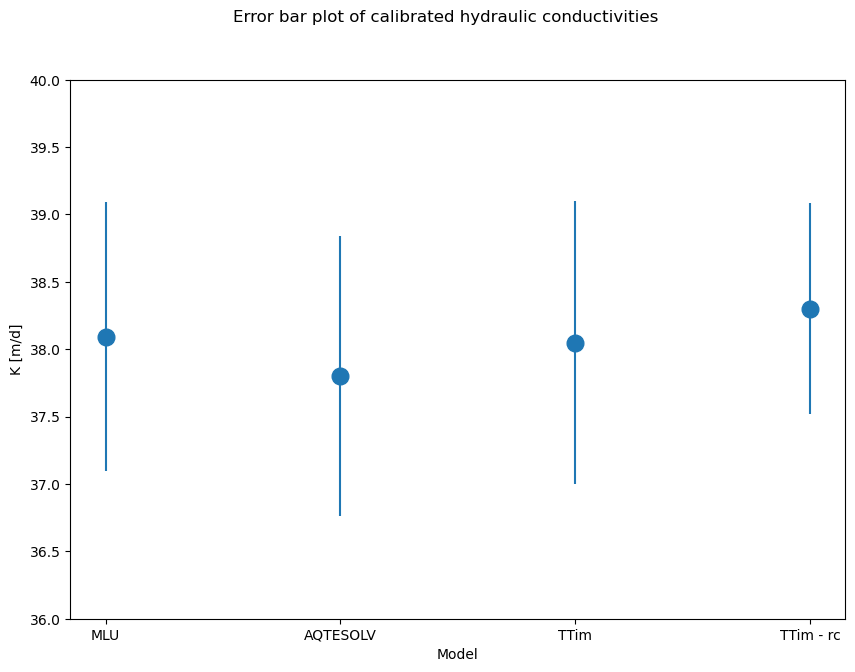

In [36]:
# Preparing the DataFrame:
t1 = pd.DataFrame(columns=['kaq - opt', 'kaq - 95%'], index = ['MLU','AQTESOLV','TTim','TTim - rc']) 
simulation = ['MLU','AQTESOLV','TTim','TTim - rc']
t1.loc['MLU'] = [38.094, 2.622*1e-2*38.094]
t1.loc['AQTESOLV'] = [37.803, 2.745*1e-2*37.803]
t1.loc['TTim'] = [ca_2.parameters.loc['kaq0','optimal'],2*ca_2.parameters.loc['kaq0','std']]
t1.loc['TTim - rc'] = [ca_4.parameters.loc['kaq0','optimal'],2*ca_4.parameters.loc['kaq0','std']]

# Plotting

plt.figure(figsize = (10,7))

plt.errorbar(x = t1.index, y = t1['kaq - opt'], yerr = [t1['kaq - 95%'], t1['kaq - 95%']],
    marker='o', linestyle='', markersize=12)
#plt.legend()
plt.suptitle("Error bar plot of calibrated hydraulic conductivities")
plt.ylabel('K [m/d]')
plt.ylim([36,40])
plt.xlabel('Model');

Error bar plot shows that TTim has similar confidence intervals to the other models. The model with wellbore storage has a slightly smaller error range.

## References

* Carlson F, Randall J (2012) MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems. Ground Water 50(4):504–510
* Duffield, G.M., 2007. AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Newville, M.,Stensitzki, T., Allen, D.B., Ingargiola, A. (2014) LMFIT: Non Linear Least-Squares Minimization and Curve Fitting for Python.https://dx.doi.org/10.5281/zenodo.11813. https://lmfit.github.io/lmfit-py/intro.html (last access: August,2021).
* Walton, W.C., 1962. Selected analytical methods for well and aquifer evaluation. Illinois.department of Registration & Education.bulletin 49.
* Yang, Xinzhu (2020) Application and comparison of different methodsfor aquifer test analysis using TTim. Master Thesis, Delft University of Technology (TUDelft), Delft, The Netherlands.